# accim: a Python library to perform building energy simulations considering adaptive comfort and data analytics

This Jupyter Notebook contains the code for the case study (Section 3 Results) of the research paper *accim: a Python library to perform building energy simulations considering adaptive comfort and data analytics*. It has been developed to ease the reproducibility of the paper, and the replicability with other IDF and EPW files or other arguments.


## 3. Results

In this case study, the aim is the analysis of energy demand resulting from the use of adaptive setpoint temperatures based on a local adaptive comfort model for office buildings in India, named IMAC-C, and the comparison with ASHRAE 55 adaptive model and static setpoints from the Indian Building Code, in different operation modes. In this study, 2 different locations, a present and a future scenario, are considered, resulting in 4 different EPW files. The simulations will be run using a very simplistic building energy model with 2 thermal zones named TestModel, since the aim of this section is to demonstrate the capabilities.

The available EPW files in this path are:

In [4]:
from os import listdir
input_files = [i for i in listdir()]
input_epws = [i for i in input_files if i.endswith('.epw')]
print(*input_epws, sep='\n')

Current_Ahmedabad-hour.epw
Current_Shimla-hour.epw
RCP852100_Ahmedabad-hour.epw
RCP852100_Shimla-hour.epw


and the available IDF file or files are:

In [5]:
input_idfs = [i for i in input_files if i.endswith('.idf')]
print(*input_idfs, sep='\n')

SmallOffice_NewDelhi.idf


At this point, the methodology explained in the research paper can be applied. It will be composed of the following sections and subsections:
- __Data pre-processing__
    - __EPW files preparation__
    - __ACCIS implementation__
- __Running simulations__
- __Data analysis__
    - __Tables__
    - __Data visualization__

## 3.1 Data pre-processing

At this stage, input files need to be prepared for simulation.

### 3.1.1.	EPW files preparation

First, EPWs will be formatted to a suitable name pattern for later simulation. To do so, the user can instantiate the class `rename_epw_files`. After instantiating the class, the user will need to interact with accim at the python console or CMD terminal. `confirm_deletion` argument has been set to ``False`` to avoid deletion of the original files, since these are needed to re-run the Jupyter Notebook

In [6]:
from accim.data.data_preprocessing import rename_epw_files
rename_epw_files(
    rename_dict={
        'Ahmedabad': 'Ahmedabad',
        'Shimla': 'Shimla'
    },
    confirm_deletion=False,
    confirm_renaming=True
)

Since no match has been found between RCP scenario Year and EPW file name, Present year has been assigned to the following EPW files:
Current_Ahmedabad-hour.epw
Current_Shimla-hour.epw
The geolocation process has taken: 1.78 seconds (0.45 s/EPW)

The previous and new names of the EPW files and their unique IDs are:
ID: 0 / Current_Ahmedabad-hour / India_Ahmedabad_Present
ID: 1 / Current_Shimla-hour / India_Shimla_Present
ID: 2 / RCP852100_Ahmedabad-hour / India_Ahmedabad_RCP85-2100
ID: 3 / RCP852100_Shimla-hour / India_Shimla_RCP85-2100

If any of the city or subcountry names needs some amendment (if you are not happy with any of the available options, you can exclude it from renaming at the next stage), please enter the EPW IDs separated by space; otherwise, hit enter to omit:

The final list of previous and new names of the EPW files and their unique IDs is:
ID: 0 / Current_Ahmedabad-hour / India_Ahmedabad_Present
ID: 1 / Current_Shimla-hour / India_Shimla_Present
ID: 2 / RCP852100_A

The tool renamed correctly all EPW files at the first instance and no amendments were required. The new EPWs are:

In [7]:
output_epws = [i for i in listdir() if i.endswith('.epw') if i not in input_epws]
print(*output_epws, sep='\n')

India_Ahmedabad_Present.epw
India_Ahmedabad_RCP85-2100.epw
India_Shimla_Present.epw
India_Shimla_RCP85-2100.epw


Now, the old EPWs need to be moved to a different folder to save them as a backup.

In [8]:
import shutil
for i in input_epws:
    shutil.move(i, f'backup/{i}')

### 3.1.2.	ACCIS implementation

The next step is applying the adaptive setpoint temperatures. To do so, the function ``addAccis`` needs to be used. Again, the recommended process, suitable for users with no programming background, is:
- open a CMD terminal pointing at the path where the EPW files to be renamed are located
- execute Python by entering ``py`` or ``python``
- import the package by entering ``from accim.sim import accis``
- call the function by entering ``accis.addAccis()``
- enter the required information on CMD terminal (related to the arguments that have not been specified)

In this case study, all arguments are specified as shown below:
-	``ScriptType`` is ``'vrf_mm'``, since this option adds a generic VRF system for each zone, and the input IDF was a generic model exported from DesignBuilder without any HVAC system at all.
-	``'temperature difference'`` in argument ``SupplyAirTempInputMethod`` specifies the type of supply air temperature input method for the VRF systems. This is due to the fact that, running simulations in hot weather with high cooling setpoint temperatures might result in little cooling needs, sometimes too little to be used with a generic cooling supply air temperature of 14°C.
-	``Output_keep_existing`` is set to ``False`` in order to not to generate unnecessary results.
-	``Output_type`` is set to ``'standard'``, in order to provide typical results. Other options might be used when a large amount of simulations is carried out and file size needs to be reduced, or when very specific results need to be exported for the testing of the tool.
-	``Output_freqs`` is set only to ``'hourly'``, since aggregation into other frequencies will be performed later in data analysis. If additional frequencies were required, these could be added to the list (i.e. ``['hourly', 'daily', 'monthly', 'runperiod']``)
-	``EnergyPlus_version`` is set to ``'23.1'``, since that is the version of TestModel.idf.
-	``TempCtrl`` is set to ``'temperature'``, so that the operation of the HVAC system is based on the operative temperature. If ``'pmv'`` was used, setpoints would be ±0.5.
-	``ComfStand`` requested values are ``2`` and ``7``, since these are the numbers respectively for ASHRAE 55 and IMAC-C in NV mode.
-	``CAT`` is set only to ``80``, so that the offset of setpoint temperatures from neutral temperature covers an 80% acceptability.
-	``ComfMod`` requested values are ``0`` and ``3``, since these are respectively for static and adaptive setpoints, and in this study, adaptive setpoints from IMAC-C and static setpoints from Indian Building Code are to be compared.
-	``HVACmode`` requested values are ``0``, ``1`` and ``2``, since those are respectively for AC, NV and MM operation modes. In this case study, may be interesting to evaluate the energy performance of MM against AC. Also, may be interesting to see the difference in comfort hours between NV and MM mode.
-	``VentCtrl``, ``VSToffset``, ``MinOToffset`` and ``MaxWindSpeed`` are arguments to control the operation of MM. In this case, the windows are opened when operative temperature exceeds the neutral temperature (``VentCtrl`` is 0) with no offset (``VSToffset`` is 0), and no restrictions in terms of minimum outdoor temperature and maximum wind speed are set (``MinOToffset`` and ``MaxWindSpeed`` are 50).
-	``ASTtol_steps``, ``ASTtol_start`` and ``ASTtol_end_input`` are mainly used to apply some tolerances to make sure there are no hours that fall outside the comfort zone by a little extent. These can also be used to generate an array of setpoint temperatures. In this case, it applies a ±0.1°C offset to heating and cooling setpoints.

In [9]:
from accim.sim import accis
accis.addAccis(
    ScriptType='vrf_mm',
    SupplyAirTempInputMethod='temperature difference',
    Output_keep_existing=False,
    Output_type='standard',
    Output_freqs=['hourly'],
    EnergyPlus_version='23.1',
    TempCtrl='temperature',
    ComfStand=[2, 7],
    CAT=[80],
    ComfMod=[0, 3],
    HVACmode=[0, 1, 2],
    VentCtrl=[0],
    VSToffset=[0],
    MinOToffset=[50],
    MaxWindSpeed=[50],
    ASTtol_steps=0.1,
    ASTtol_start=0.1,
    ASTtol_end_input=0.1,
    confirmGen=True,
)


--------------------------------------------------------
Adaptive-Comfort-Control-Implemented Model (ACCIM)
--------------------------------------------------------

This tool allows to apply adaptive setpoint temperatures. 
For further information, please read the documentation: 
https://accim.readthedocs.io/en/master/
For a visual understanding of the tool, please visit the following jupyter notebooks:
-    Using addAccis() to apply adaptive setpoint temperatures
https://github.com/dsanchez-garcia/accim/blob/master/accim/sample_files/jupyter_notebooks/addAccis/using_addAccis.ipynb
-    Using rename_epw_files() to rename the EPWs for proper data analysis after simulation
https://github.com/dsanchez-garcia/accim/blob/master/accim/sample_files/jupyter_notebooks/rename_epw_files/using_rename_epw_files.ipynb
-    Using runEp() to directly run simulations with EnergyPlus
https://github.com/dsanchez-garcia/accim/blob/master/accim/sample_files/jupyter_notebooks/runEp/using_runEp.ipynb
-    

AHST_Sch_BLOCK1_PERIMETERXZNX3 Schedule has been added
ACST_Sch_BLOCK1_PERIMETERXZNX3 Schedule has been added
Added - SetComfTemp Program
Added - CountHours_BLOCK1_PERIMETERXZNX4 Program
Added - CountHours_BLOCK1_COREXZN Program
Added - CountHours_BLOCK1_PERIMETERXZNX2 Program
Added - CountHours_BLOCK1_PERIMETERXZNX1 Program
Added - CountHours_BLOCK1_PERIMETERXZNX3 Program
Added - SetAppLimits Program
Added - ApplyCAT Program
Added - SetAST Program
Added - SetASTnoTol Program
Added - CountHoursNoApp_BLOCK1_PERIMETERXZNX4 Program
Added - SetGeoVarBLOCK1_PERIMETERXZNX4 Program
Added - CountHoursNoApp_BLOCK1_COREXZN Program
Added - SetGeoVarBLOCK1_COREXZN Program
Added - CountHoursNoApp_BLOCK1_PERIMETERXZNX2 Program
Added - SetGeoVarBLOCK1_PERIMETERXZNX2 Program
Added - CountHoursNoApp_BLOCK1_PERIMETERXZNX1 Program
Added - SetGeoVarBLOCK1_PERIMETERXZNX1 Program
Added - CountHoursNoApp_BLOCK1_PERIMETERXZNX3 Program
Added - SetGeoVarBLOCK1_PERIMETERXZNX3 Program
Added - SetInputData Program

IDF has been saved
Ending with file:
SmallOffice_NewDelhi

=======================END OF GENERIC IDF FILE GENERATION PROCESS=======================

The following IDFs will not work, and therefore these will be deleted:
None

=======================START OF OUTPUT IDF FILES GENERATION PROCESS=======================

The list of output IDFs is going to be:
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT

As a result, 12 output IDFs are generated:

In [10]:
output_idfs = [i for i in listdir() if i.endswith('.idf') and i not in input_idfs]
print(*output_idfs, sep='\n')

SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_1[VC_

However, not all of them are necessary. The IDFs that are needed are listed below (also in Table 7 of the research paper):

In [11]:
necessary_idfs = [
    'SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf',
    'SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf',
    'SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf',
    'SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf',
    'SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf'    
]
print(*necessary_idfs, sep='\n')

SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf


Thus, the remaining, shown below, should be removed to avoid unnecessary computational effort.

In [12]:
idfs_to_be_removed = [i for i in listdir() if i.endswith('.idf') and i not in necessary_idfs and i not in input_idfs]
print(*idfs_to_be_removed, sep='\n')
from os import remove
for i in idfs_to_be_removed:
    remove(i)

SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_0[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf


At this point, all EPWs have been formatted to a suitable file name and adaptive setpoint temperatures have been implemented in the input IDFs, so simulations can be run.

## 3.2.	Running simulations

Once EPWs have been formatted and adaptive setpoint temperatures have been implemented in the output IDFs, simulations can be automatically run using the function runEp. Again, the recommended process, suitable for users with no programming background, is:
- open a CMD terminal pointing at the path where the renamed EPWs and IDFs are located
- execute Python by entering ``py`` or ``python``
- import the package by entering ``from accim.run import run``
- call the function by entering ``run.runEp()``
- enter the required information on CMD terminal (related to the arguments that have not been specified)

In this case study, all arguments are specified:
- ``runOnlyAccim`` is set to ``True``, since only output IDFs need to be simulated;
- ``confirmRun`` is set to ``True``, since the number of simulation runs is known (5 IDFs x 4 EPWs = 20 runs), otherwise, if the user were not sure of the number, it could lead to some memory errors or undesired results;
- ``num_CPUs`` is set to ``4``, to be suitable for most computers;
- ``EnergyPlus_version`` is set to ``'23.1'``, since the EnergyPlus version of the output IDFs is known.

Therefore, no interaction with the user is needed and simulation can be automatically run:

In [13]:
from accim.run import run
run.runEp(
    runOnlyAccim=True, #only runs output IDFs, that is, IDFs with "[" in its name
    confirmRun=True, #to skip confirmation
    num_CPUs=4, #to specify the number of CPUs to be used
    EnergyPlus_version='23.1', #to specify the EnergyPlus version of the IDF, and the version of EnergyPlus you are going to run
)

The IDFs we are going to run are:
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_2[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_INT ASHRAE55[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
 and the No. of IDFs is going to be 5
The sample_EPWs we are going to run are:
India_Ahmedabad_Present.epw
India_Ahmedabad_RCP85-2100.epw
India_Shimla_Present.epw
India_Shimla_RCP85-2100.epw
 and the No. of sample_EPWs is going to be 4
Therefore, the simulations are going to be:
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_RCP85-210

The simulation output files have been saved in the same path. In this case study 20 simulations have been run, therefore there must be 20 CSV files ready to be analysed, which are shown below:

In [5]:
from os import listdir
csvs = [i for i in listdir() if i.endswith('.csv') and 'Zsz.csv' not in i and 'Table.csv' not in i and 'Meter.csv' not in i]
print(*csvs, sep='\n')

SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_RCP85-2100.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Shimla_Present.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Shimla_RCP85-2100.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_RCP85-2100.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Shimla_Present.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Shimla_RCP85-2100.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_1[VC_0[VO_0.0[MT_50.0[MW_50.0[AT_0.1

## 3.3.	Data analysis

In the following subsections, the CSV files resulting from the simulation runs will be analysed, to provide a table to assess the energy demand differences, and to visualize the data in multiple figures. In this case, it is recommended to use an IDE instead of a CMD terminal.

### 3.3.1 Tables

The aim of this subsection is to create a table to see how much energy is demanded in the different settings. To do so, the first step would be to generate a DataFrame instance using the class ``Table``, which is going to be stored in variable ``dataset_runperiod``. The arguments are specified as follows:

-	``datasets`` is set to a list of all CSV files except those in which operation mode is NV (HM_1), since energy demand is 0
-	``source_frequency`` is set to ``'hourly'``, since that is the frequency that has been used when the output IDFs were generated.
-	``frequency`` is set to ``'runperiod'``, since the target table is intended to have only 1 row per simulation run
-	``frequency_agg_func`` is set to ``'sum'``, since all hourly energy demand values must be summed on a runperiod frequency basis.
-	``standard_outputs`` is set to ``True``, to use only a controlled range of outputs.
-	``level`` is set only to ``'building'``, since the target table should show the sum of energy demand values from all thermal zones.
-	``level_agg_func`` is set only to ``'sum'``, since only summed values of all zones are necessary.
-	``level_excluded_zones`` is set to ``'ATTIC:ATTIC'``. If the user opens the IDF file, 2 blocks can be found: ATTIC and Block1. In this case, the block ATTIC contains only one zone named ATTIC as well, which is not air-conditioned. Therefore, it should be omitted in the calculations.
-	``split_epw_names`` is set to ``True``, since the EPWs have previously formatted to analyse the locations and climate scenarios


In [6]:
from accim.data.data_postprocessing import Table
dataset_runperiod = Table(
    datasets=[i for i in csvs if 'HM_1' not in i],
    source_frequency='hourly',
    frequency='runperiod',
    frequency_agg_func='sum',
    standard_outputs=True,
    level=['building'],
    level_agg_func=['sum'],
    level_excluded_zones=['ATTIC:ATTIC'],
    split_epw_names=True,
)

If the user needs to see the DataFrame instance that has been created, it can be accessed at the variable ``df`` stored within the class ``dataset_runperiod`` as shown below:

In [7]:
dataset_runperiod.df

,Source,Model,ComfStand,CAT,ComfMod,HVACmode,VentCtrl,VSToffset,MinOToffset,MaxWindSpeed,...,Building_Total_Cooling Energy Demand (kWh/m2) (summed),Building_Total_Heating Energy Demand (kWh/m2) (summed),Building_Total_Cooling Energy Consumption (kWh/m2) (summed),Building_Total_Heating Energy Consumption (kWh/m2) (summed),Building_Total_Total Energy Demand (kWh/m2) (summed),Building_Total_Total Energy Consumption (kWh/m2) (summed),Building_Total_Zone Air Volume (m3) (summed),Building_Total_Zone Floor Area (m2) (summed),Building_Total_PMV (summed),Building_Total_PPD (%) (summed)
0,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,283.832881,0.000434,165.205508,0.000306,283.833315,165.205814,753.3405,246.9969,0.0,0.0
1,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,340.094920,0.000000,208.099314,0.000000,340.094920,208.099314,753.3405,246.9969,0.0,0.0
2,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,151.413820,6.620035,85.904458,5.296678,158.033855,91.201136,753.3405,246.9969,0.0,0.0
3,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,200.268096,1.079250,114.460020,0.821372,201.347345,115.281392,753.3405,246.9969,0.0,0.0
4,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,216.999009,0.000000,146.597120,0.000000,216.999009,146.597120,753.3405,246.9969,0.0,0.0
5,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,250.841748,0.000000,175.832081,0.000000,250.841748,175.832081,753.3405,246.9969,0.0,0.0
6,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,167.472028,0.044523,100.295186,0.033055,167.516551,100.328241,753.3405,246.9969,0.0,0.0
7,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,191.533866,0.000000,119.709614,0.000000,191.533866,119.709614,753.3405,246.9969,0.0,0.0
8,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,122.315856,1.075044,93.284693,0.484408,123.390900,93.769101,753.3405,246.9969,0.0,0.0
9,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,...,190.902614,0.093708,141.871776,0.042341,190.996321,141.914116,753.3405,246.9969,0.0,0.0


Then, the method ``format_table`` needs to be executed, to filter only energy demand columns at building level, where:
-	``type_of_table`` is set to ``'custom'``, so that specifically the columns specified in custom_cols are filtered
-	``custom_cols`` is a list of the columns that should be kept, namely heating, cooling and total energy demand at building level


To know exactly the name of the energy demand columns at building level, the user can access to the DataFrame instance and search in the columns. For instance, the code below searches the string "energy demand" in all columns and print the results.

In [15]:
energy_demand_cols = [i for i in dataset_runperiod.df.columns if 'energy demand' in i.lower()]
print(*energy_demand_cols, sep='\n')

BLOCK1:PERIMETERXZNX4_Cooling Energy Demand (kWh/m2)
BLOCK1:COREXZN_Cooling Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX2_Cooling Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX1_Cooling Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX3_Cooling Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX4_Heating Energy Demand (kWh/m2)
BLOCK1:COREXZN_Heating Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX2_Heating Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX1_Heating Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX3_Heating Energy Demand (kWh/m2)
BLOCK1:PERIMETERXZNX4_Total Energy Demand (kWh/m2) (summed)
BLOCK1:COREXZN_Total Energy Demand (kWh/m2) (summed)
BLOCK1:PERIMETERXZNX2_Total Energy Demand (kWh/m2) (summed)
BLOCK1:PERIMETERXZNX1_Total Energy Demand (kWh/m2) (summed)
BLOCK1:PERIMETERXZNX3_Total Energy Demand (kWh/m2) (summed)
Building_Total_Cooling Energy Demand (kWh/m2) (summed)
Building_Total_Heating Energy Demand (kWh/m2) (summed)
Building_Total_Total Energy Demand (kWh/m2) (summed)


In this case, only columns at building level are necessary, therefore these are specified when the format_table method is called below:

In [36]:
dataset_runperiod.format_table(
    type_of_table='custom',
    custom_cols=[
        'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
        'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
        'Building_Total_Total Energy Demand (kWh/m2) (summed)'
    ]
)

Again, if the user needs to see how the DataFrame instance has been modified, it can be accessed at the variable ``df`` stored within the class ``dataset_runperiod`` as shown below:

In [37]:
dataset_runperiod.df

,Model,ComfStand,CAT,ComfMod,HVACmode,VentCtrl,VSToffset,MinOToffset,MaxWindSpeed,ASTtol,...,EPW,Source,EPW_Country_name,EPW_City_or_subcountry,EPW_Scenario-Year,EPW_Scenario,EPW_Year,Building_Total_Cooling Energy Demand (kWh/m2) (summed),Building_Total_Heating Energy Demand (kWh/m2) (summed),Building_Total_Total Energy Demand (kWh/m2) (summed)
0,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Ahmedabad_Present,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Ahmedabad,Present,Present,Present,283.832881,0.000434,283.833315
1,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Ahmedabad_RCP85-2100,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Ahmedabad,RCP85-2100,RCP85,2100,340.094920,0.000000,340.094920
2,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Shimla_Present,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Shimla,Present,Present,Present,151.413820,6.620035,158.033855
3,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Shimla_RCP85-2100,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Shimla,RCP85-2100,RCP85,2100,200.268096,1.079250,201.347345
4,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Ahmedabad_Present,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Ahmedabad,Present,Present,Present,216.999009,0.000000,216.999009
5,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Ahmedabad_RCP85-2100,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Ahmedabad,RCP85-2100,RCP85,2100,250.841748,0.000000,250.841748
6,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Shimla_Present,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Shimla,Present,Present,Present,167.472028,0.044523,167.516551
7,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,AT_0.1,...,India_Shimla_RCP85-2100,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Shimla,RCP85-2100,RCP85,2100,191.533866,0.000000,191.533866
8,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,AT_0.1,...,India_Ahmedabad_Present,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Ahmedabad,Present,Present,Present,122.315856,1.075044,123.390900
9,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_3,HM_2,VC_0,VO_0.0,MT_50.0,MW_50.0,AT_0.1,...,India_Ahmedabad_RCP85-2100,SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM...,India,Ahmedabad,RCP85-2100,RCP85,2100,190.902614,0.093708,190.996321


At this point, the user might have a vague idea of what table can be done with the available data, especially if there is a large number of categorical variables. In order to get a clearer idea of this, the user can call the method named ``gather_vars_query``. It only takes one argument, named ``vars_to_gather``, which should be a list of the variables to be combined.

In this case, when IDFs with adaptive setpoint were generated, the arguments where more than one than one value were requested were ComfStand, ComfMod and HVACmode (``ComfStand=[2, 7], ComfMod=[0, 3], HVACmode=[0, 1, 2]``). Therefore, these are all the categorical variables that change regarding the IDFs and the possibilities that might be interesting to study, and therefore the variables that have been entered in ``vars_to_gather``.

Then, after calling ``gather_vars_query``, accim prints on screen the categorical variables that contains more than one different value (i.e. ComfMod, since values are “CM_0” and “CM_3”), and the different combinations based on the combined variables, joined by character “[“:

In [38]:
dataset_runperiod.gather_vars_query(
    vars_to_gather=[
        'ComfStand',
        'ComfMod',
        'HVACmode'
    ]
)

The categorical columns which have different values and those values are:
ComfStand: ['CS_IND IMAC C NV', 'CS_INT ASHRAE55']
ComfMod: ['CM_0', 'CM_3']
HVACmode: ['HM_0', 'HM_2']
EPW_City_or_subcountry: ['Ahmedabad', 'Shimla']
EPW_Scenario-Year: ['Present', 'RCP85-2100']
EPW_Scenario: ['Present', 'RCP85']
EPW_Year: ['Present', '2100']
The available options resulting from the data entered in vars_to_gather would be: 
CS_IND IMAC C NV[CM_0[HM_0
CS_IND IMAC C NV[CM_3[HM_0
CS_IND IMAC C NV[CM_3[HM_2
CS_INT ASHRAE55[CM_3[HM_0


At this point, the user should be aware of the possibilities to be studied, and therefore can confidently run the method ``wrangled_table`` to get the target table, where the following arguments are specified:
-	``reshaping`` is set to ``'unstack'``, since some variables in the rows should be moved to the columns.
-	``vars_to_gather`` is set to “ComfStand”, “ComfMod” and “HVACmode”, as previously showed in method ``gather_vars_query``.
-	``baseline`` is set to ``'CS_IND IMAC C NV[CM_3[HM_2'``, which is the setting that this case study intends to analyse.
-	``vars_to_keep`` is set to ``'EPW_City_or_subcountry'``, ``'EPW_Scenario'`` and ``'EPW_Year'``, since these are the remaining categorical variables apart from those specified in vars_to_gather.
-	``comparison_mode`` is only set to ``'baseline compared to others'``, since only the variance of the baseline respect to all other combinations must be shown.
-	``comparison_cols`` is only set to ``'relative'``, since absolute differences are not needed.
-	``rename_dict`` is a dictionary following the acronyms from Table 7 in research paper and available options previously shown in method ``gather_vars_query``.
-	``transpose`` is set to ``True``, since the untransposed was not in a suitable shape.


In [39]:
dataset_runperiod.wrangled_table(
    reshaping='unstack',
    vars_to_gather=['ComfStand', 'ComfMod', 'HVACmode'],
    baseline='CS_IND IMAC C NV[CM_3[HM_2',
    vars_to_keep=['EPW_City_or_subcountry', 'EPW_Scenario', 'EPW_Year'],
    comparison_mode=['baseline compared to others'],
    comparison_cols=['relative'],
    rename_dict={
        'CS_IND IMAC C NV[CM_0[HM_0': 'Ind_Stat_AC',
        'CS_IND IMAC C NV[CM_3[HM_0': 'Ind_Adap_AC',
        'CS_IND IMAC C NV[CM_3[HM_2': 'Ind_Adap_MM',
        'CS_INT ASHRAE55[CM_3[HM_0': 'ASH_Adap_AC'
    },
    transpose=True,
    excel_filename='testing_accim'
)

Finally, an Excel spreadsheet named ``'testing_accim.xlsx'`` as specified in ``excel_filename`` argument, is created and saved in the same path where the method was called. The Excel spreadsheet is read and shown below (also in Table 8, in the research paper):

In [40]:
import pandas as pd
output_xlsx = pd.read_excel('testing_accim.xlsx', index_col=[0, 1], header=[0, 1, 2])
output_xlsx

EPW_City_or_subcountry                                                         Ahmedabad  \
EPW_Scenario                                                                     Present   
EPW_Year                                                                         Present   
Building_Total_Cooling Energy Demand (kWh/m2) (... Ind_Stat_AC                    283.83   
                                                   Ind_Adap_AC                    217.00   
                                                   Ind_Adap_MM                    122.32   
                                                   ASH_Adap_AC                    250.70   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)      0.57   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)      0.44   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)      0.51   
Building_Total_Heating Energy Demand (kWh/m2) (... Ind_Stat_AC                      0.00   
                                                   Ind_Adap_AC                      0.00   
                                                   Ind_Adap_MM                      1.08   
                                                   ASH_Adap_AC                      0.00   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)  -2477.57   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)      -inf   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)      -inf   
Building_Total_Total Energy Demand (kWh/m2) (su... Ind_Stat_AC                    283.83   
                                                   Ind_Adap_AC                    217.00   
                                                   Ind_Adap_MM                    123.39   
                                                   ASH_Adap_AC                    250.70   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)      0.57   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)      0.43   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)      0.51   

EPW_City_or_subcountry                                                                  \
EPW_Scenario                                                                     RCP85   
EPW_Year                                                                          2100   
Building_Total_Cooling Energy Demand (kWh/m2) (... Ind_Stat_AC                  340.09   
                                                   Ind_Adap_AC                  250.84   
                                                   Ind_Adap_MM                  190.90   
                                                   ASH_Adap_AC                  291.64   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)    0.44   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)    0.24   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)    0.35   
Building_Total_Heating Energy Demand (kWh/m2) (... Ind_Stat_AC                    0.00   
                                                   Ind_Adap_AC                    0.00   
                                                   Ind_Adap_MM                    0.09   
                                                   ASH_Adap_AC                    0.00   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)    -inf   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)    -inf   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)    -inf   
Building_Total_Total Energy Demand (kWh/m2) (su... Ind_Stat_AC                  340.09   
                                                   Ind_Adap_AC                  250.84   
                                                   Ind_Adap_MM                  1

The user can also access the ``wrangled_table`` output at the variable stored within the class ``dataset_runperiod``, depending on the ``reshaping`` method used:
- for ``'pivot'``, ``'wrangled_df_pivoted'``
- for ``'unstack'``, ``'wrangled_df_unstacked'``,
- for ``'stack'``, ``'wrangled_df_stacked'``,
- for ``'multiindex'``, ``'wrangled_df_multiindex'``

In this case, with ``'unstack'``:

In [41]:
dataset_runperiod.wrangled_df_unstacked

EPW_City_or_subcountry                                                         Ahmedabad  \
EPW_Scenario                                                                     Present   
EPW_Year                                                                         Present   
Building_Total_Cooling Energy Demand (kWh/m2) (... Ind_Stat_AC                    283.83   
                                                   Ind_Adap_AC                    217.00   
                                                   Ind_Adap_MM                    122.32   
                                                   ASH_Adap_AC                    250.70   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)      0.57   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)      0.44   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)      0.51   
Building_Total_Heating Energy Demand (kWh/m2) (... Ind_Stat_AC                      0.00   
                                                   Ind_Adap_AC                      0.00   
                                                   Ind_Adap_MM                      1.08   
                                                   ASH_Adap_AC                      0.00   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)  -2477.57   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)      -inf   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)      -inf   
Building_Total_Total Energy Demand (kWh/m2) (su... Ind_Stat_AC                    283.83   
                                                   Ind_Adap_AC                    217.00   
                                                   Ind_Adap_MM                    123.39   
                                                   ASH_Adap_AC                    250.70   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)      0.57   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)      0.43   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)      0.51   

EPW_City_or_subcountry                                                                  \
EPW_Scenario                                                                     RCP85   
EPW_Year                                                                          2100   
Building_Total_Cooling Energy Demand (kWh/m2) (... Ind_Stat_AC                  340.09   
                                                   Ind_Adap_AC                  250.84   
                                                   Ind_Adap_MM                  190.90   
                                                   ASH_Adap_AC                  291.64   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)    0.44   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)    0.24   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)    0.35   
Building_Total_Heating Energy Demand (kWh/m2) (... Ind_Stat_AC                    0.00   
                                                   Ind_Adap_AC                    0.00   
                                                   Ind_Adap_MM                    0.09   
                                                   ASH_Adap_AC                    0.00   
                                                   1-(Ind_Adap_MM/Ind_Stat_AC)    -inf   
                                                   1-(Ind_Adap_MM/Ind_Adap_AC)    -inf   
                                                   1-(Ind_Adap_MM/ASH_Adap_AC)    -inf   
Building_Total_Total Energy Demand (kWh/m2) (su... Ind_Stat_AC                  340.09   
                                                   Ind_Adap_AC                  250.84   
                                                   Ind_Adap_MM                  1

### 3.3.2.	Data visualization

The aim of this subsection is to plot figures that represent the results of the building energy simulations with adaptive setpoint temperatures. Methods ``scatter_plot``, ``scatter_plot_with_baseline`` and ``time_plot`` need to be called after method ``format_table``. However, the class Table instance created at the previous section had runperiod ``frequency``, which would be translated into very simple and not interesting figures, and besides NV mode was not considered. Therefore, a new instance will be created in this case using hourly ``frequency``, in order to plot hourly values of indoor temperature and energy demand among others.

In [6]:
from accim.data.data_postprocessing import Table
dataset_hourly = Table(
    source_frequency='hourly',
    frequency='hourly',
    frequency_agg_func='sum',
    standard_outputs=True,
    level=['building'],
    level_agg_func=['mean', 'sum'],
    level_excluded_zones=['ATTIC:ATTIC'],
    split_epw_names=True,
)

Input data frequency in file SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_RCP85-2100.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Shimla_Present.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Shimla_RCP85-2100.csv is hourly, therefore no aggregation will be performed.
Input data frequency in file SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_3[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.csv is hourly, therefore no aggregation will be performed.
Input data

In this case, ``format_table`` will be called using the parameter ``type_of_table`` “temperature”, which will provide the mean operative temperature of all air conditioned zones, the adaptive setpoint temperatures, a value of running mean outdoor temperature of a single zone (since it is the same for all of them), and the building total heating and cooling energy demands.

In [7]:
dataset_hourly.format_table(
    type_of_table='custom',
    custom_cols=[
        'BLOCK1:PERIMETERXZNX4_ASHRAE 55 Running mean outdoor temperature (°C)',
        'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
        'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
        'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
        'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
        'Building_Total_Zone Operative Temperature (°C) (mean)'
    ]
)

Now, the user can see which are the columns of the DataFrame instance:

In [8]:
dataset_hourly.df.columns

Index(['Date/time', 'Model', 'ComfStand', 'CAT', 'ComfMod', 'HVACmode',
       'VentCtrl', 'VSToffset', 'MinOToffset', 'MaxWindSpeed', 'ASTtol',
       'NameSuffix', 'EPW', 'Source', 'Month', 'Day', 'Hour',
       'EPW_Country_name', 'EPW_City_or_subcountry', 'EPW_Scenario-Year',
       'EPW_Scenario', 'EPW_Year',
       'BLOCK1:PERIMETERXZNX4_ASHRAE 55 Running mean outdoor temperature (°C)',
       'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
       'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
       'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
       'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
       'Building_Total_Zone Operative Temperature (°C) (mean)'],
      dtype='object')

In [9]:
dataset_hourly.df

,Date/time,Model,ComfStand,CAT,ComfMod,HVACmode,VentCtrl,VSToffset,MinOToffset,MaxWindSpeed,...,EPW_City_or_subcountry,EPW_Scenario-Year,EPW_Scenario,EPW_Year,BLOCK1:PERIMETERXZNX4_ASHRAE 55 Running mean outdoor temperature (°C),Building_Total_Cooling Energy Demand (kWh/m2) (summed),Building_Total_Heating Energy Demand (kWh/m2) (summed),Adaptive Cooling Setpoint Temperature_No Tolerance (°C),Adaptive Heating Setpoint Temperature_No Tolerance (°C),Building_Total_Zone Operative Temperature (°C) (mean)
0,01/01 01:00:00,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,Ahmedabad,Present,Present,Present,20.659722,0.000296,0.0,27.312882,21.872882,25.880542
1,01/01 02:00:00,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,Ahmedabad,Present,Present,Present,20.659722,0.000000,0.0,27.581458,22.141458,25.856296
2,01/01 03:00:00,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,Ahmedabad,Present,Present,Present,20.659722,0.000000,0.0,27.581458,22.141458,25.775176
3,01/01 04:00:00,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,Ahmedabad,Present,Present,Present,20.659722,0.000000,0.0,27.581458,22.141458,25.671719
4,01/01 05:00:00,SmallOffice_NewDelhi,CS_IND IMAC C NV,CA_80,CM_0,HM_0,VC_X,VO_X,MT_X,MW_X,...,Ahmedabad,Present,Present,Present,20.659722,0.000000,0.0,27.581458,22.141458,25.563558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175195,12/31 20:00:00,SmallOffice_NewDelhi,CS_INT ASHRAE55,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,Shimla,RCP85-2100,RCP85,2100,11.446157,0.008958,0.0,24.848309,17.848309,24.697415
175196,12/31 21:00:00,SmallOffice_NewDelhi,CS_INT ASHRAE55,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,Shimla,RCP85-2100,RCP85,2100,11.446157,0.000000,0.0,24.848309,17.848309,24.041390
175197,12/31 22:00:00,SmallOffice_NewDelhi,CS_INT ASHRAE55,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,Shimla,RCP85-2100,RCP85,2100,11.446157,0.000000,0.0,24.848309,17.848309,23.331536
175198,12/31 23:00:00,SmallOffice_NewDelhi,CS_INT ASHRAE55,CA_80,CM_3,HM_0,VC_X,VO_X,MT_X,MW_X,...,Shimla,RCP85-2100,RCP85,2100,11.446157,0.000000,0.0,24.848309,17.848309,22.855234


Once ``format_table`` has been called, the methods to create the figures can follow. First, ``scatter_plot`` method will be used, in which the typical plot to show the linear regression of adaptive comfort models will be generated. As specified in the arguments below, the variables “ComfStand”, “ComfMod” and “HVACmode” were gathered and the different combinations are plotted in rows, while “EPW_City_or_subcountry” and “EPW_Scenario-Year” combinations are plotted in the columns. Data on main y-axis (left) was heating and cooling energy demand, while setpoint temperatures and operative temperature were plotted on the secondary y-axis (right), following the colours specified in the arguments. Finally, these were renamed following the dictionaries entered.

The number of rows and the list of these is going to be:
No. of rows = 5
List of rows:
CS_IND IMAC C NV[CM_0[HM_0
CS_IND IMAC C NV[CM_3[HM_0
CS_IND IMAC C NV[CM_3[HM_1
CS_IND IMAC C NV[CM_3[HM_2
CS_INT ASHRAE55[CM_3[HM_0
The renamed rows are going to be:
IND_Stat_AC
IND_Adap_AC
IND_Adap_NV
IND_Adap_MM
ASH_Adap_AC
The number of columns and the list of these is going to be:
No. of columns = 4
List of columns:
Ahmedabad[Present
Ahmedabad[RCP85-2100
Shimla[Present
Shimla[RCP85-2100
The renamed columns are going to be:
Ahmedabad Present
Ahmedabad RCP85-2100
Shimla Present
Shimla RCP85-2100


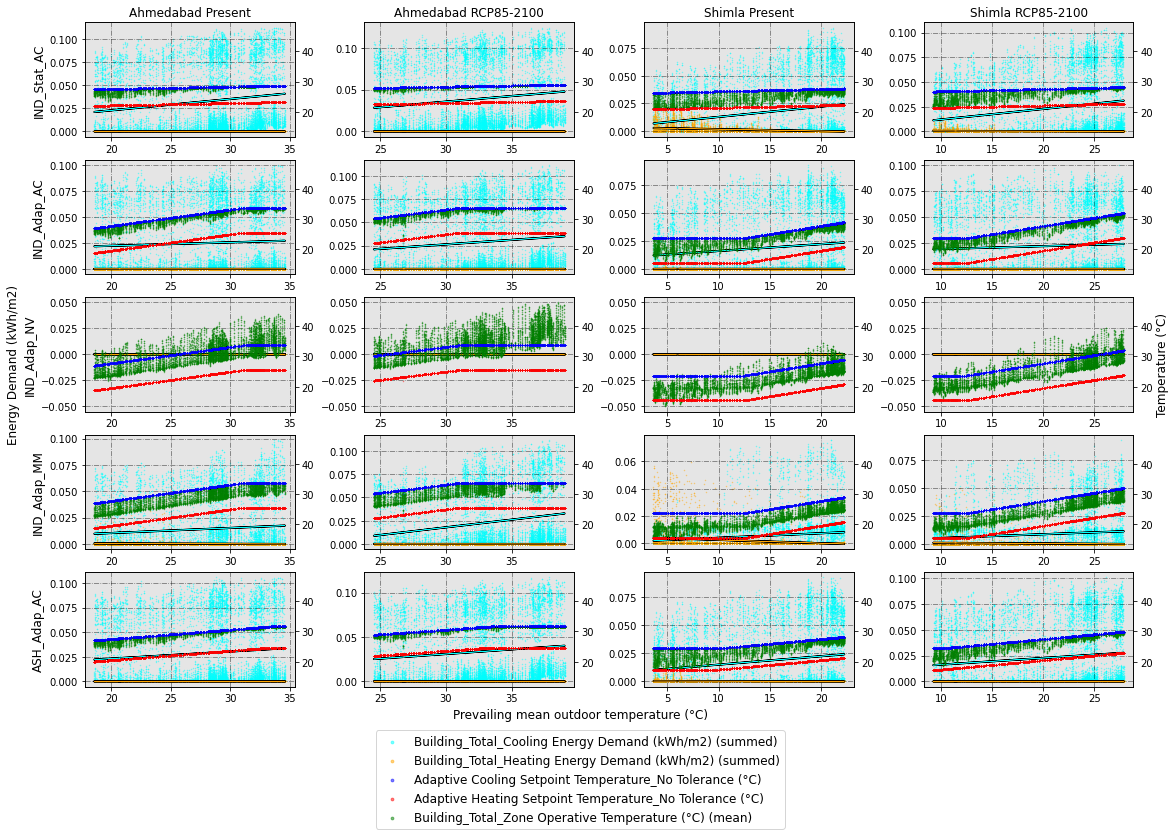

In [4]:
dataset_hourly.scatter_plot(
    vars_to_gather_rows=['ComfStand', 'ComfMod', 'HVACmode'],
    vars_to_gather_cols=['EPW_City_or_subcountry', 'EPW_Scenario-Year'],
    data_on_x_axis='BLOCK1:PERIMETERXZNX4_ASHRAE 55 Running mean outdoor temperature (°C)',
    data_on_y_main_axis=[
        [
            'Energy Demand (kWh/m2)',
            [
                'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
                'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
            ]
        ],
    ],
    data_on_y_sec_axis=[
        [
            'Temperature (°C)',
            [
                'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
                'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
                'Building_Total_Zone Operative Temperature (°C) (mean)'
            ]
        ],
    ],
    colorlist_y_main_axis=[
        [
            'Energy Demand (kWh/m2)',
            [
                'cyan',
                'orange',
            ]
        ],
    ],
    colorlist_y_sec_axis=[
        [
            'Temperature (°C)',
            [
                'blue',
                'red',
                'green'
            ]
        ],
    ],
        best_fit_deg_y_main_axis=[
        [
            'Energy Demand (kWh/m2)',
            [
                1,
                1,
            ]
        ],
    ],
    cols_renaming_dict={
        'Ahmedabad[Present': 'Ahmedabad Present',
        'Ahmedabad[RCP85-2100': 'Ahmedabad RCP85-2100',
        'Shimla[Present': 'Shimla Present',
        'Shimla[RCP85-2100': 'Shimla RCP85-2100'
    },
    rows_renaming_dict={
        'CS_IND IMAC C NV[CM_0[HM_0': 'IND_Stat_AC',
        'CS_IND IMAC C NV[CM_3[HM_0': 'IND_Adap_AC',
        'CS_IND IMAC C NV[CM_3[HM_1': 'IND_Adap_NV',
        'CS_IND IMAC C NV[CM_3[HM_2': 'IND_Adap_MM',
        'CS_INT ASHRAE55[CM_3[HM_0': 'ASH_Adap_AC'
    },
    sharex=False,
    sharey=False,
    supxlabel='Prevailing mean outdoor temperature (°C)',
    figname='testing_scatterplot_case_study',
    figsize=4,
    ratio_height_to_width=0.5,
    dpi=300,
    confirm_graph=True
)

Using a similar code snippet but changing method to ``time_plot`` and omitting the argument ``data_on_x_axis``, a figure with time on the x-axis can be generated. In this case, the argument ``sharex`` is also omitted, since the simulation period is the same for all cases.

The number of rows and the list of these is going to be:
No. of rows = 5
List of rows:
CS_IND IMAC C NV[CM_0[HM_0
CS_IND IMAC C NV[CM_3[HM_0
CS_IND IMAC C NV[CM_3[HM_1
CS_IND IMAC C NV[CM_3[HM_2
CS_INT ASHRAE55[CM_3[HM_0
The renamed rows are going to be:
IND_Stat_AC
IND_Adap_AC
IND_Adap_NV
IND_Adap_MM
ASH_Adap_AC
The number of columns and the list of these is going to be:
No. of columns = 4
List of columns:
Ahmedabad[Present
Ahmedabad[RCP85-2100
Shimla[Present
Shimla[RCP85-2100
The renamed columns are going to be:
Ahmedabad Present
Ahmedabad RCP85-2100
Shimla Present
Shimla RCP85-2100


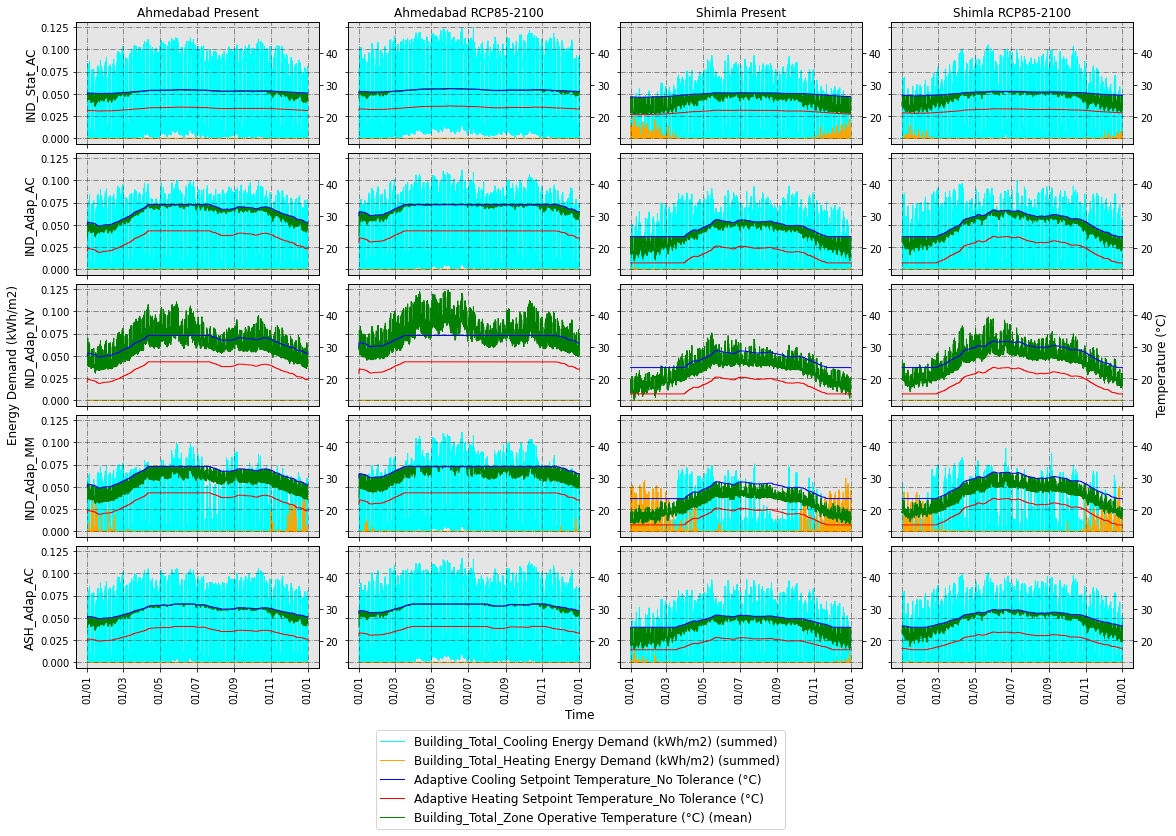

In [49]:
dataset_hourly.time_plot(
    vars_to_gather_rows=['ComfStand', 'ComfMod', 'HVACmode'],
    vars_to_gather_cols=['EPW_City_or_subcountry', 'EPW_Scenario-Year'],
    data_on_y_main_axis=[
        [
            'Energy Demand (kWh/m2)',
            [
                'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
                'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
            ]
        ],
    ],
    data_on_y_sec_axis=[
        [
            'Temperature (°C)',
            [
                'Adaptive Cooling Setpoint Temperature_No Tolerance (°C)',
                'Adaptive Heating Setpoint Temperature_No Tolerance (°C)',
                'Building_Total_Zone Operative Temperature (°C) (mean)'
            ]
        ],
    ],
    colorlist_y_main_axis=[
        [
            'Energy Demand (kWh/m2)',
            [
                'cyan',
                'orange',
            ]
        ],
    ],
    colorlist_y_sec_axis=[
        [
            'Temperature (°C)',
            [
                'blue',
                'red',
                'green'
            ]
        ],
    ],
    cols_renaming_dict={
        'Ahmedabad[Present': 'Ahmedabad Present',
        'Ahmedabad[RCP85-2100': 'Ahmedabad RCP85-2100',
        'Shimla[Present': 'Shimla Present',
        'Shimla[RCP85-2100': 'Shimla RCP85-2100'
    },
    rows_renaming_dict={
        'CS_IND IMAC C NV[CM_0[HM_0': 'IND_Stat_AC',
        'CS_IND IMAC C NV[CM_3[HM_0': 'IND_Adap_AC',
        'CS_IND IMAC C NV[CM_3[HM_1': 'IND_Adap_NV',
        'CS_IND IMAC C NV[CM_3[HM_2': 'IND_Adap_MM',
        'CS_INT ASHRAE55[CM_3[HM_0': 'ASH_Adap_AC'
    },

    sharey=True,
    figname='testing_timeplot_case_study',
    figsize=4,
    ratio_height_to_width=0.5,
    dpi=300,
    confirm_graph=True
)

Finally, using ``scatter_plot_with_baseline`` a different scatter plot can be generated. In this case, it is mainly used to compare some combination of variables gathered in columns with the remaining variants. In the example below, the total heating and cooling energy demands will be compared using the combination ``'CS_IND IMAC C NV[CM_3[HM_2'`` (or IND_Adap_MM) as the baseline, since it is expected to provide the greater energy savings. The same ``Table`` instance will be used, however, to avoid plotting an empty figure, since energy demand is null in the combination ``'CS_IND IMAC C NV[CM_3[HM_1'`` (or IND_Adap_NV), since it is on naturally ventilated mode, the argument ``detailed_cols`` is used. In this argument, all the combinations to be plotted are specified, that is, all of them except the NV and the baseline.

The number of rows and the list of these is going to be:
No. of rows = 4
List of rows:
Ahmedabad[Present
Ahmedabad[RCP85-2100
Shimla[Present
Shimla[RCP85-2100
The renamed rows are going to be:
Ahmedabad Present
Ahmedabad RCP85-2100
Shimla Present
Shimla RCP85-2100
The number of columns and the list of these is going to be:
No. of columns = 3
List of columns:
CS_IND IMAC C NV[CM_0[HM_0
CS_IND IMAC C NV[CM_3[HM_0
CS_INT ASHRAE55[CM_3[HM_0
The renamed columns are going to be:
IND_Stat_AC
IND_Adap_AC
ASH_Adap_AC


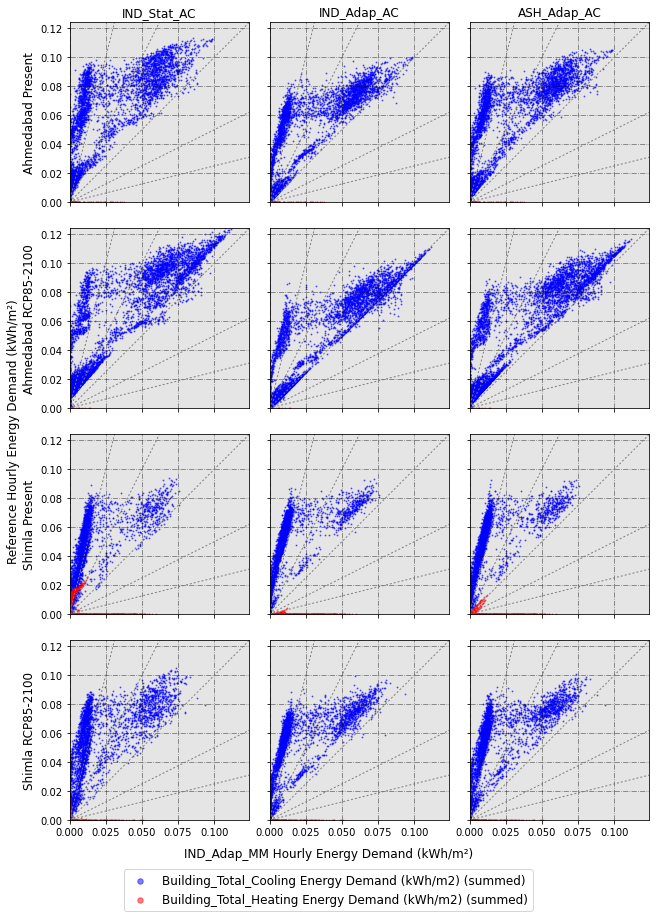

In [11]:
dataset_hourly.scatter_plot_with_baseline(
    vars_to_gather_rows=['EPW_City_or_subcountry', 'EPW_Scenario-Year'],
    vars_to_gather_cols=['ComfStand', 'ComfMod', 'HVACmode'],
    detailed_cols=[
        'CS_IND IMAC C NV[CM_0[HM_0',
        'CS_IND IMAC C NV[CM_3[HM_0',
        'CS_INT ASHRAE55[CM_3[HM_0'
    ],
    data_on_y_axis_baseline_plot=[
                'Building_Total_Cooling Energy Demand (kWh/m2) (summed)',
                'Building_Total_Heating Energy Demand (kWh/m2) (summed)',
    ],
    colorlist_baseline_plot_data=[
                'blue',
                'red'
    ],
    baseline='CS_IND IMAC C NV[CM_3[HM_2',
    rows_renaming_dict={
        'Ahmedabad[Present': 'Ahmedabad Present',
        'Ahmedabad[RCP85-2100': 'Ahmedabad RCP85-2100',
        'Shimla[Present': 'Shimla Present',
        'Shimla[RCP85-2100': 'Shimla RCP85-2100'
    },
    cols_renaming_dict={
        'CS_IND IMAC C NV[CM_0[HM_0': 'IND_Stat_AC',
        'CS_IND IMAC C NV[CM_3[HM_0': 'IND_Adap_AC',
        'CS_INT ASHRAE55[CM_3[HM_0': 'ASH_Adap_AC'
    },
    supxlabel='IND_Adap_MM Hourly Energy Demand (kWh/m²)',
    supylabel='Reference Hourly Energy Demand (kWh/m²)',
    figname='testing_scatterplotbaseline_case_study',
    figsize=3,
    dpi=300,
    confirm_graph=True
)

Finally, so that this jupyter notebook can be properly run again, all files different than the input ones will be deleted.

In [29]:
for i in input_epws:
    shutil.move(f'backup/{i}', i)

In [30]:
files_to_delete = [i for i in listdir() if i not in input_files]
print(*files_to_delete, sep='\n')

India_Ahmedabad_Present.epw
India_Ahmedabad_RCP85-2100.epw
India_Shimla_Present.epw
India_Shimla_RCP85-2100.epw
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X.idf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.audit
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.bnd
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.csv
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.dxf
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.eio
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.end
SmallOffice_NewDelhi[CS_IND IMAC C NV[CA_80[CM_0[HM_0[VC_X[VO_X[MT_X[MW_X[AT_0.1[NS_X[India_Ahmedabad_Present.er

In [31]:
for i in files_to_delete:
    remove(i)